Table of contents


In [40]:
#import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
#read in meta data csv
df=pd.read_csv('full_metadata.csv')

In [13]:
#look at the first few rows
df.head()

,class_id,slang,scientific_name,herbarium22_category_id,path,toxicity,species_label
0,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3
1,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3
2,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3
3,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3
4,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3


In [23]:
#get overview of data
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9952 entries, 0 to 9951
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   class_id                 9952 non-null   int64 
 1   slang                    9952 non-null   object
 2   scientific_name          9952 non-null   object
 3   herbarium22_category_id  9952 non-null   int64 
 4   path                     9952 non-null   object
 5   toxicity                 9952 non-null   int64 
 6   species_label            9952 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 544.4+ KB


class_id                      5
slang                        10
scientific_name              10
herbarium22_category_id      10
path                       9952
toxicity                      2
species_label                 4
dtype: int64


  No blank data.  
class_id and species_label should both have 10 unique values. let's investigate

In [35]:
#group by class_id and slang column(which has the correct number of unique values)
df.groupby(['class_id', 'slang'], as_index=False).first()

,class_id,slang,scientific_name,herbarium22_category_id,path,toxicity,species_label
0,0,Virginia creeper,Parthenocissus quinquefolia,10340,../input/toxic-plant-classification/tpc-imgs/n...,0,3
1,0,Western Poison Oak,Toxicodendron diversilobum,14625,../input/toxic-plant-classification/tpc-imgs/t...,1,0
2,1,Boxelder,Acer negundo L.,83,../input/toxic-plant-classification/tpc-imgs/n...,0,3
3,1,Eastern Poison Oak,Toxicodendron pubescens,14626,../input/toxic-plant-classification/tpc-imgs/t...,1,0
4,2,Eastern Poison Ivy,Toxicodendron radicans,14627,../input/toxic-plant-classification/tpc-imgs/t...,1,1
5,2,Jack-in-the-pulpit,Arisaema triphyllum,1055,../input/toxic-plant-classification/tpc-imgs/n...,0,3
6,3,Bear Oak,Quercus ilicifolia,12267,../input/toxic-plant-classification/tpc-imgs/n...,0,3
7,3,Western Poison Ivy,Toxicodendron rydbergii,14628,../input/toxic-plant-classification/tpc-imgs/t...,1,1
8,4,Fragrant Sumac,Rhus aromatica,12479,../input/toxic-plant-classification/tpc-imgs/n...,0,3
9,4,Poison Sumac,Toxicodendron vernix,14629,../input/toxic-plant-classification/tpc-imgs/t...,1,2


The dataset reuses the same class_id 0-4 for the toxic plants group and the non-toxic plants group, resulting in 2 sets of class id 0-4

Now let's visualize the balance of plant species samples and toxicity samples

[Text(0, 0, '4999'), Text(0, 0, '4953')]

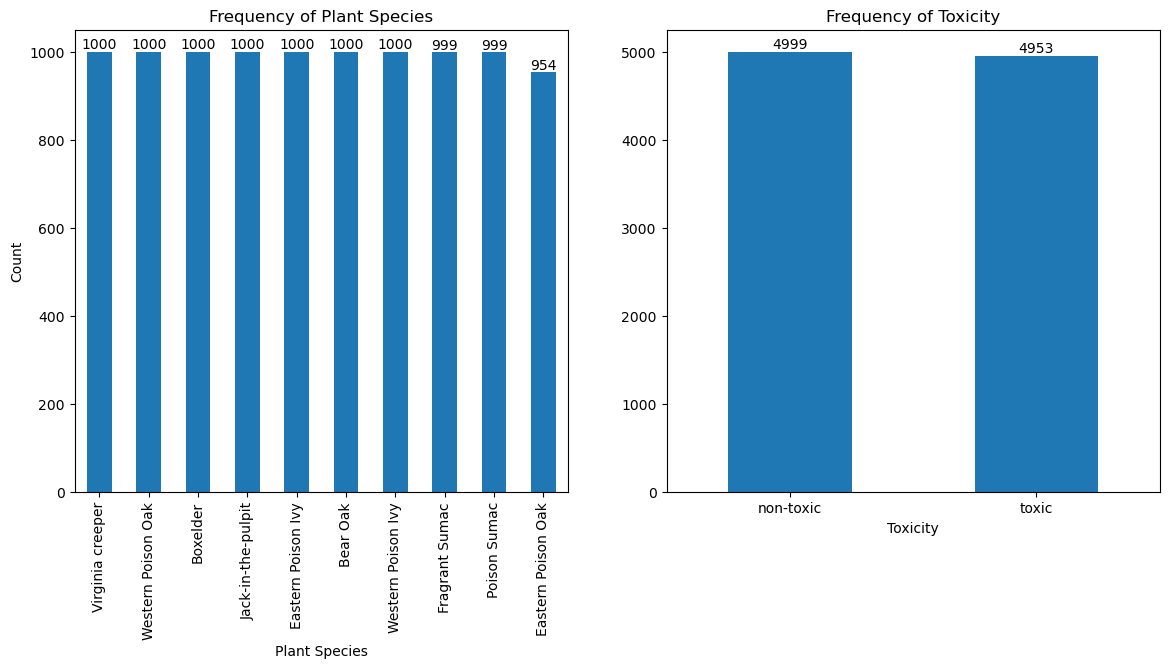

In [105]:
#create a subplot for 2 plots
fig, axes = plt.subplots(1,2, figsize=(14, 6))

#plot the number of each plant species in the first plot
species=df['slang'].value_counts().plot(kind='bar', ax=axes[0])
#set the title, labels, and show values
axes[0].set_title('Frequency of Plant Species')
axes[0].set_xlabel('Plant Species')
axes[0].set_ylabel('Count')
axes[0].bar_label(species.containers[0])

#plot the number of toxic vs non toxic plants in the second plot
toxicity=df['toxicity'].value_counts().plot(kind='bar', ax=axes[1])
#set the title, labels, and show values
axes[1].set_title('Frequency of Toxicity')
axes[1].set_xlabel('Toxicity')
axes[1].set_xticklabels(['non-toxic', 'toxic'])
axes[1].tick_params(axis='x', rotation=0)
axes[1].bar_label(toxicity.containers[0])


The classes are balanced within the 10 plant species (9 out of 10 classes have 999 or 1,000 samples, with the remaining class having 954) and within the toxic vs non-toxic plants (4,999 vs 4,953 samples). The slightly fewer samples of Eastern Poison Oak should not be enough to cause a class imbalance issue.

CNN's work best with consistent input shapes. Let's look at the dimensions of all the images to see how we should reshape them.

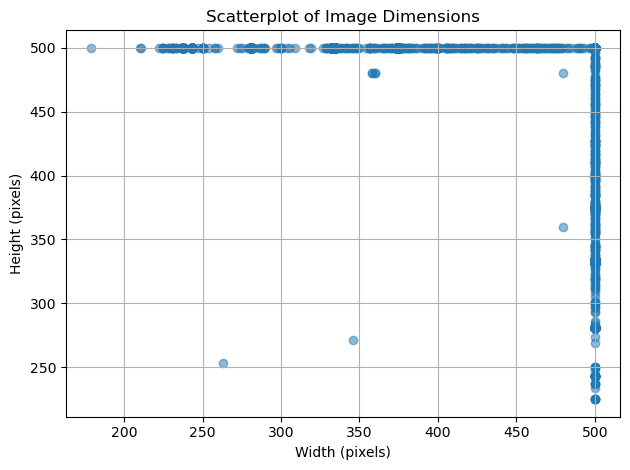

CPU times: total: 19 s
Wall time: 19.5 s


In [146]:
%%time

# Set base directory to the top-level folder
base_dir = 'raw images'  

# Lists to store dimensions and paths
widths = []
heights = []
paths = []

# Loop through folders
for tox_folder in ['nontoxic_images', 'toxic_images']:
    tox_path = os.path.join(base_dir, tox_folder)
    for subfolder in os.listdir(tox_path):
        subfolder_path = os.path.join(tox_path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    img_path = os.path.join(subfolder_path, file)
                    try:
                        img = imread(img_path)
                        h, w = img.shape[:2]
                        widths.append(w)
                        heights.append(h)
                        paths.append(img_path)
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")

# Plot scatterplot
plt.scatter(widths, heights, alpha=0.5)
plt.title('Scatterplot of Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the graph, most of the images have either a height or a width of 500 pixels. We will store the info in a dataframe to explore it more.

In [184]:
#complie dimensions into a dataframe
df_dims = pd.DataFrame({'width': widths,'height': heights, 'path':paths})

#confirm statement above that most images have either a height or width of 500
count_500 = ((df_dims['height'] == 500) | (df_dims['width'] == 500)).sum()
count_other = ((df_dims['height'] != 500) & (df_dims['width'] != 500)).sum()

print(f"Number of images with height or width equal to 500: {count_500}")
print(f"Number of images with height and width not equal to 500: {count_other}")

Number of images with height or width equal to 500: 9944
Number of images with height and width not equal to 500: 8


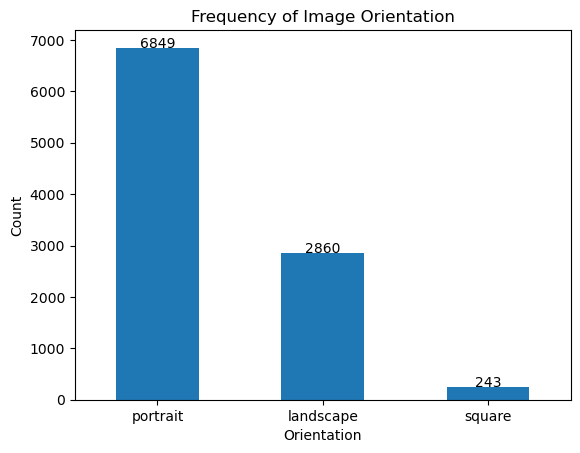

In [197]:
#create a column to state the orientation of the image
df_dims['orientation'] = np.where(df_dims['height'] > df_dims['width'], 'portrait',
    np.where(df_dims['height'] < df_dims['width'], 'landscape', 'square'))
df_dims.head()

#plot the count of each orientation
df_dims['orientation'].value_counts().plot(kind='bar')
plt.title('Frequency of Image Orientation')
plt.xlabel('Orientation')
plt.xticks(rotation=0)
plt.ylabel('Count')
#add the values to the plot
for i, value in enumerate(df_dims['orientation'].value_counts()):
    plt.text(i, value + 1, str(value), ha='center')



Approximately 69% of the images are portrait, 29% are landscape, and 2% are square

In [200]:
#get summary statistics
print(df_dims.nunique())
df_dims.describe()

width           169
height          173
path           9952
orientation       3
dtype: int64


,width,height
count,9952.000000,9952.000000
mean,406.752713,460.440314
std,68.852072,65.000861
min,179.000000,225.000000
25%,375.000000,375.000000
50%,375.000000,500.000000
75%,500.000000,500.000000
max,500.000000,500.000000


There are 169 different width dimensions, with the smallest being 179 pixels, and 173 different height dimensions with the smallest being 225. The maximum pixels for both height and width is 500.  

I think the best option for resizing would be to use zero or mean padding. The question is do i resize first then do augmentation, or do the augmentation first, then resize, so the zero padding is all in the same area?